In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
import xrft 
from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40343 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40343/status,
Dashboard: /proxy/40343/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45975,Workers: 7
Dashboard: /proxy/40343/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40281,Total threads: 4
Dashboard: /proxy/45963/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37641,


## Load the along beam data

In [2]:
output = "0*"
surface = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/surface.nc",decode_times = False)
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/u/*",decode_times = False).u
v = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/v/*",decode_times = False).v
e = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/e/*",decode_times = False).e
rho = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/rho/*",decode_times = False).rho
bathy = e.isel(time = 0,rho2_i = 0)

## Temporally filter outputs 

Filter in chunks of 10 tidal periods, staggered over 5 tidal periods. The overlaps will be averaged

i.e

i = 0
previous data = array of zeros
loop:
1. new data = Filter from `t=i` until `i+10` tidal periods
2. previous data = mean (previous data , new data)
3. save previous data somewhere
4. previous data = new data

Continue until we run out of complete 10 tidal period chunks of data. Then, save the last 5 tidal periods as the final part of time series.



In [3]:
def filter(field,freq,tol = 0.01):
    FIELD = xrft.fft(field,dim = "time")
    FIELD_filtered = FIELD.where(np.abs(np.abs(FIELD.freq_time) - freq) < tol,0)
    return np.real(xrft.ifft(FIELD_filtered,dim = "freq_time"))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


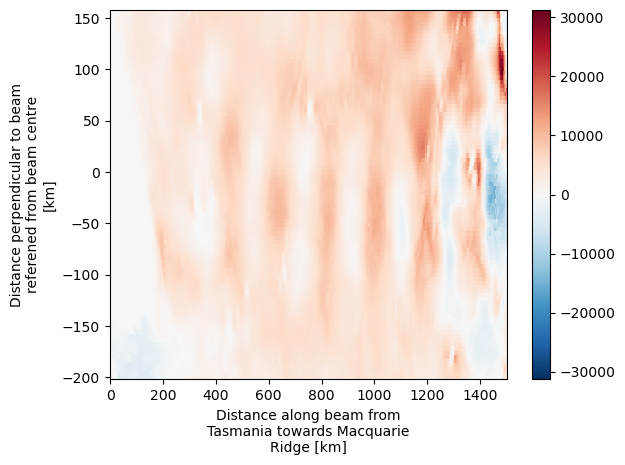

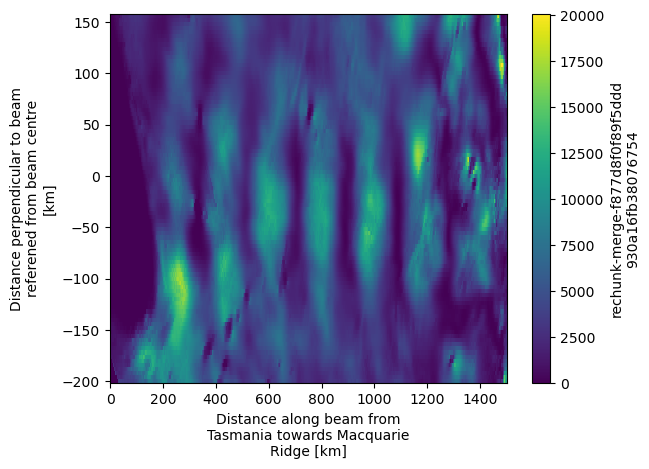

In [20]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(50,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
vf = filter(
    v.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(50,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
(uf * vf).mean("time").plot()
plt.figure()
(uf * uf).mean("time").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


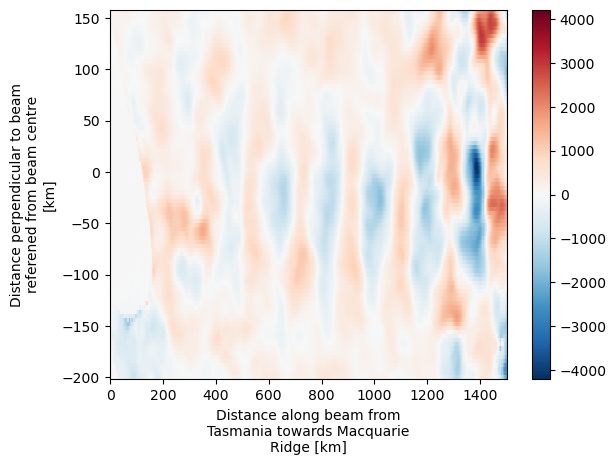

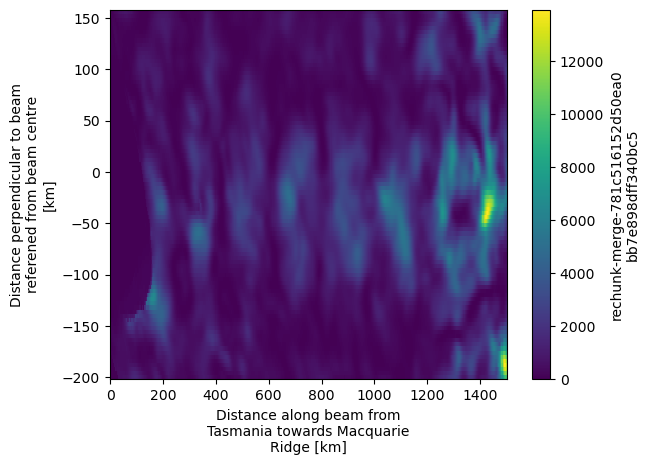

In [19]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(0,50)).integrate("zl").drop(["lat","lon"]),
    m2f)
vf = filter(
    v.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(0,50)).integrate("zl").drop(["lat","lon"]),
    m2f)
(uf * vf).mean("time").plot()
plt.figure()
(uf * uf).mean("time").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


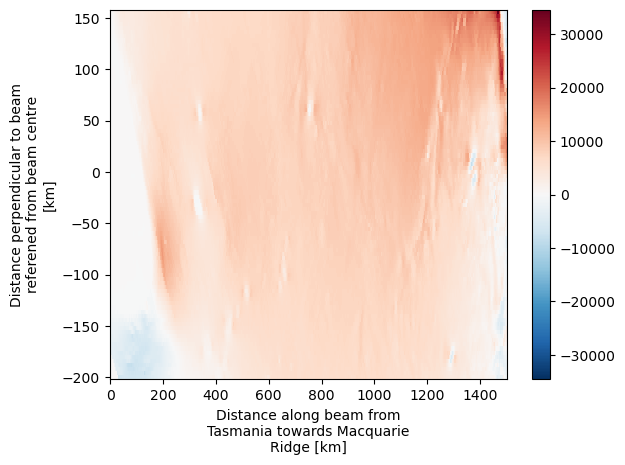

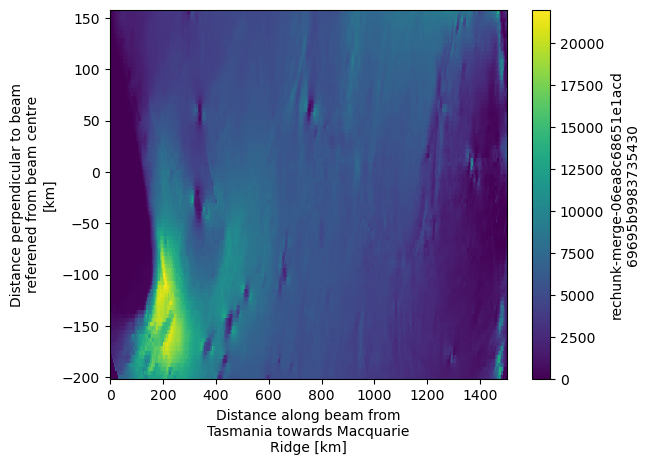

In [21]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(0,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
vf = filter(
    v.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(0,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
(uf * vf).mean("time").plot()
plt.figure()
(uf * uf).mean("time").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


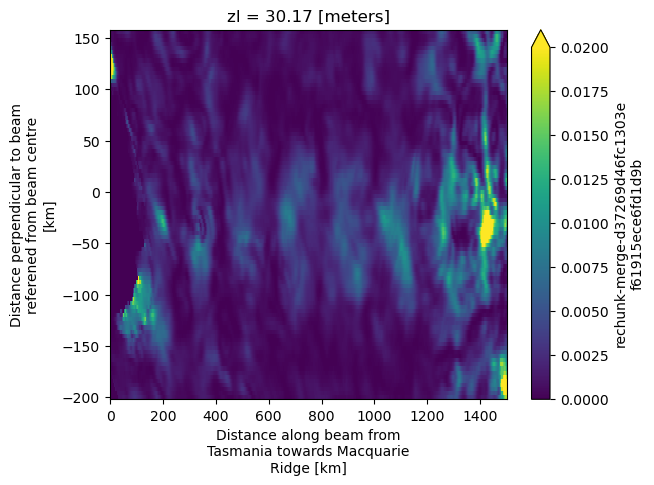

In [13]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = 5),
    m2f)
# vf = 
(uf**2 + vf**2).mean("time").plot(vmax = 0.02)

In [24]:
m2 = 360 / 28.984104 ## Period of m2 in hours
m2f = 1/ m2    ## Frequency of m2 in radians per hour
tol = 0.01
t0 = 213361
i = 0
u = u.fillna(0)
v = v.fillna(0)


averaging_window = int(12 * m2) ## this comes out to be 149.0472 hours, so close enough to a multiple of tidal periods

def hef(u,v,i):

    u_ = u.sel(
            time = slice(t0 + i,t0 + i + m2 * 12)
            ).chunk({"time":-1}).drop(["lat","lon"])
    v_ = v.sel(
            time = slice(t0 + i,t0 + i + m2 * 12)
            ).chunk({"time":-1}).drop(["lat","lon"])

    uf = filter(
        u_,
        m2f)
    vf = filter(
        v_,
        m2f)

    dux = u_.mean("time").differentiate("xb")
    dvy = v_.mean("time").differentiate("yb")
    duy = u_.mean("time").differentiate("yb")
    dvx = v_.mean("time").differentiate("xb")

    nstress_u = (uf * uf).mean("time")
    nstress_v = (vf * vf).mean("time")
    n_strain = dux - duy

    shear = (uf * vf).mean("time")
    shear_strain = duy + dvx
    return ((nstress_u - nstress_v) * n_strain - shear * shear_strain).isel(zl = slice(0,50)).integrate("zl")
# total = (nstress_u - nstress_v) * n_strain - shear * shear_strain
# total.integrate("zl").plot()


surface...


Text(0.5, 1.0, 'Surface Speed')

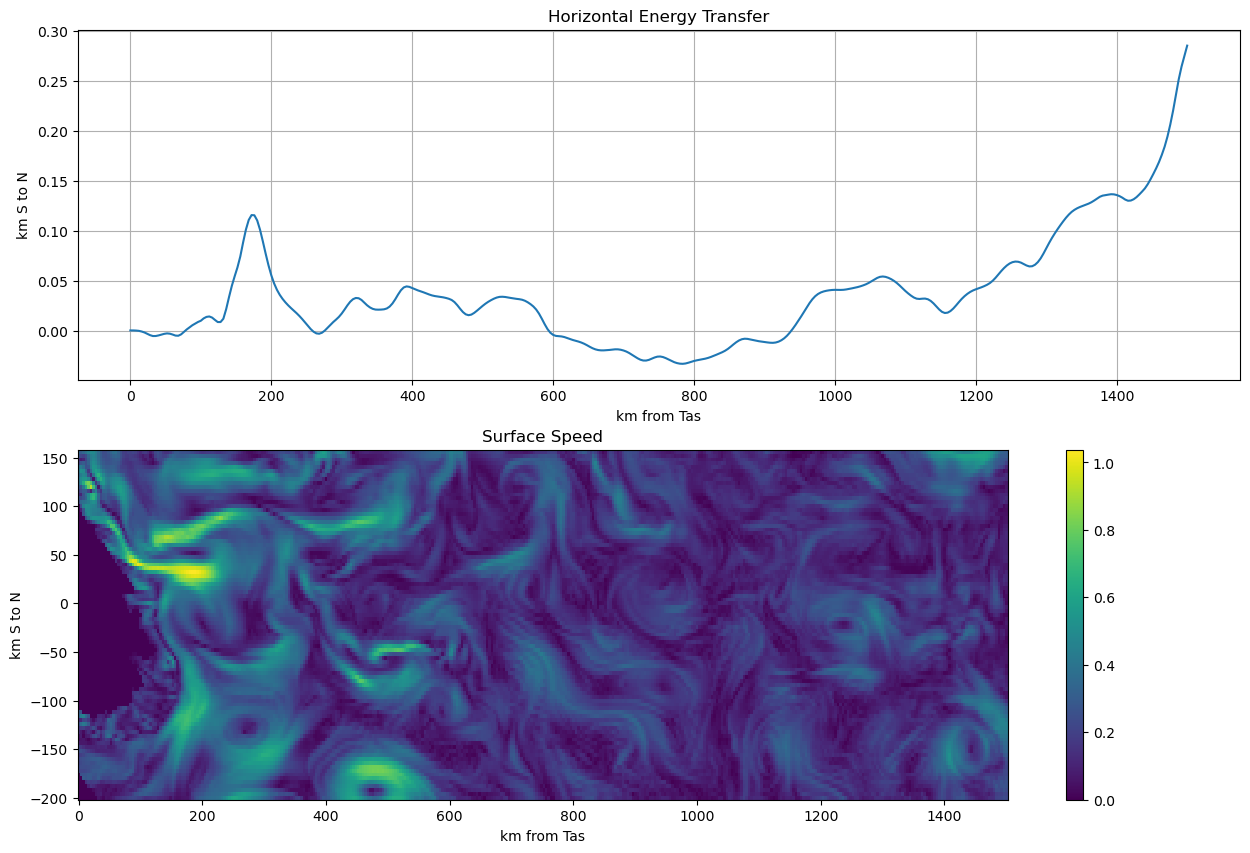

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# total = hef(u,v,10).persist()
# total.plot(ax = axs[0],vmin = -0.2,vmax = 0.2,cmap = "RdBu")
total.mean("yb").cumsum("xb").plot(ax = axs[0])

axs[0].set_xlabel('km from Tas')
axs[0].set_ylabel('km S to N')
axs[0].set_title('Horizontal Energy Transfer')
print("surface...")
## put gridlines on plot
axs[0].grid(True, which='both')
# speed = np.sqrt(u**2 + v**2).sel(time = t0 + i + m2 * 6,method = "nearest").isel(zl = 0).persist()
speed.plot(ax = axs[1])
axs[1].set_xlabel('km from Tas')
axs[1].set_ylabel('km S to N')
axs[1].set_title('Surface Speed')


In [5]:

for i in range(10,30):
    print(i)
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    total = hef(u,v,i).persist()
    total.plot(ax = axs[0],vmin = -0.2,vmax = 0.2,cmap = "RdBu")
    axs[0].set_xlabel('km from Tas')
    axs[0].set_ylabel('km S to N')
    axs[0].set_title('Horizontal Energy Transfer')
    # print("surface...")
    speed = np.sqrt(u**2 + v**2).sel(time = t0 + i + m2 * 6,method = "nearest").isel(zl = 0).persist()
    speed.plot(ax = axs[1])
    axs[1].set_xlabel('km from Tas')
    axs[1].set_ylabel('km S to N')
    axs[1].set_title('Surface Speed')
    plt.savefig(f"/g/data/v45/ab8992/dropbox/regional_movies/hef{i}.png")
    plt.clf()

10


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

11


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

13


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

14


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

15


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

16


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

2023-11-14 10:12:14,184 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42305'.
2023-11-14 10:12:14,187 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36689'.
2023-11-14 10:12:14,189 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35049'.
2023-11-14 10:12:14,191 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33375'.
2023-11-14 10:12:14,193 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43967'.
2023-11-14 10:12:14,194 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43283'.
2023-11-14 10:12:14,197 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39359'.


In [29]:
ke = (uf**2 + vf**2).integrate("zl").mean("time").persist()

2023-11-13 17:21:19,581 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 13.13 GiB -- Worker memory limit: 16.00 GiB
2023-11-13 17:21:20,044 - distributed.worker.memory - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 8.88 GiB -- Worker memory limit: 16.00 GiB


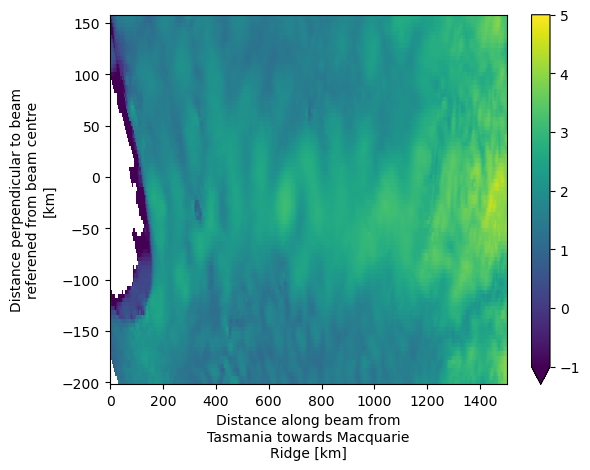

In [30]:
np.log(ke).plot(vmax = 5,vmin = -1)

In [20]:
uf

<xarray.DataArray 'rechunk-merge-5d41647d0fe4ba16cd18177763f53fbc' (time: 150,
                                                                    zl: 100,
                                                                    yb: 90,
                                                                    xb: 376)>
dask.array<real, shape=(150, 100, 90, 376), dtype=float64, chunksize=(150, 100, 10, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 148.0 152.0 156.0
    lat      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
    lon      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
  * time     (time) float64 2.134e+05 2.134e+05 ... 2.135e+05 2.135e+05

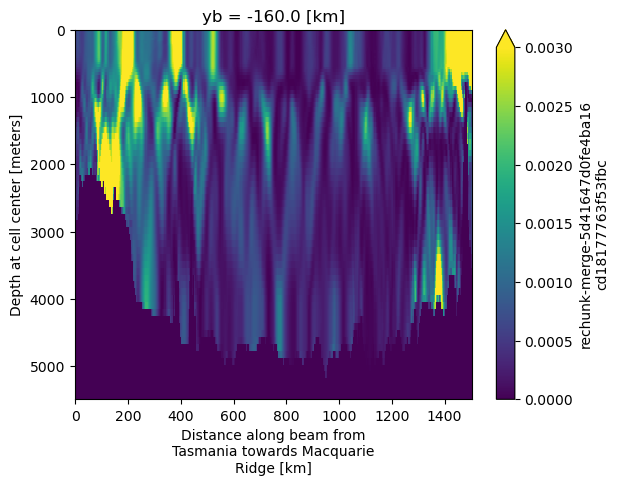

In [17]:
(uf**2).isel(yb = 10).mean("time").plot(vmax = 0.003)
## invert the y axis of existing plot
plt.gca().invert_yaxis()
# bathy.isel(yb = 10).plot()


## Find the best isopycnal layers for outputting e
We'll do this by finding the average densities along each isopycnal height along transect

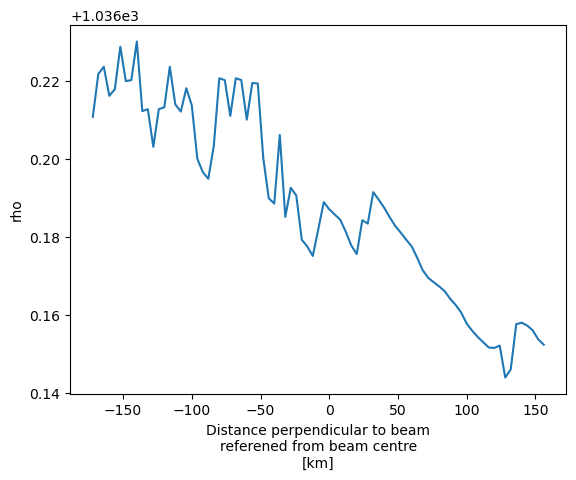

In [5]:
rho.isel(time = slice(0,200),yb = slice(7,None)).mean("time").mean("xb").mean("zl").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


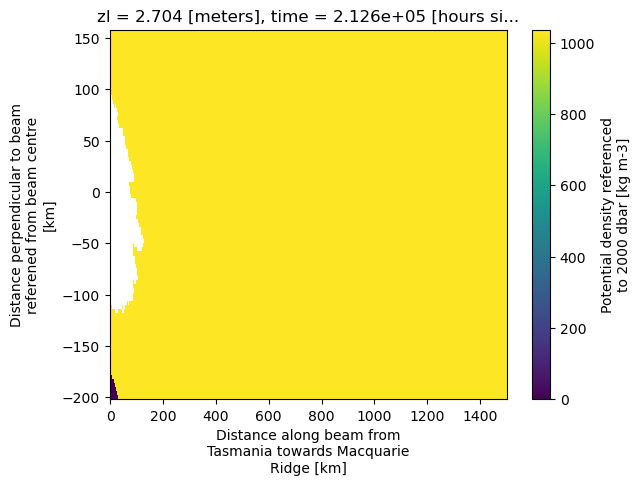

In [24]:
rho.isel(zl = 0,time = 5).plot()

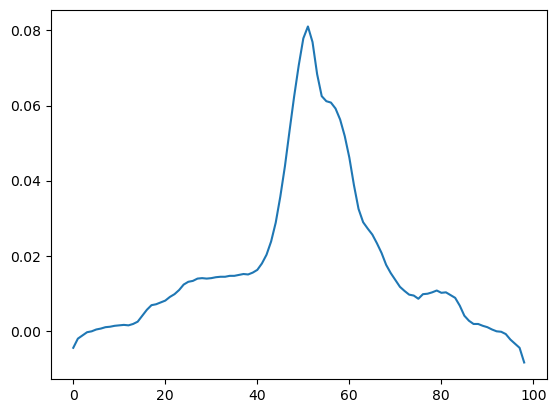

In [16]:
profile = rho.isel(time = slice(0,200),yb = slice(7,None)).mean("time").mean("xb").mean("yb")
drho = profile.values[1:] - profile.values[:-1]

plt.plot(drho)
## Make a new numpy array containing all the values of drho when they are greater than 0.005


In [28]:
new  = profile[1:].values[drho > 0.005]
new_rho2diag = xr.Dataset(
    {
        "nrho":(["nrho"],np.arange(len(new))),
        "rho2":(["nrho"],new)
        })
new_rho2diag

## encode all the variables as double
for var in new_rho2diag.variables:
    new_rho2diag[var].encoding["dtype"] = "float64"
## set units as kg m-3
new_rho2diag.rho2.attrs["units"] = "kg m-3"
new_rho2diag.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/synbath/diag_rho2.nc")